In [1]:
%load_ext autoreload
%autoreload 2
import ECGHandle

from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import random

import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,precision_recall_curve

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False
    
fontdict = {'family' : 'Times New Roman', 'size' : 10}
plt.rc('font',family='Times New Roman')
plt.rcParams['font.sans-serif'] = ['SimHei'] #或者把"SimHei"换为"KaiTi"
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    

/root/miniconda3/envs/ECG_torch_1.11/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data) # 剔除labelNan的数据，将label转换为0,1
ALL_data = ECGHandle.filter_ID(ALL_data)  #剔除ID为Nan的数据
ALL_data = ECGHandle.filter_QC(ALL_data)  #剔除QC为Nan的数据
ALL_data = ECGHandle.filter_ages(ALL_data,18) #剔除年龄大于18的数据
ALL_data = ALL_data[ALL_data['住院号'].astype(str).map(len)==6] #剔除ALL_data中的ID不为6位数的数据
print('\n')
print("{:^10} {:^10} {:^20}".format('原始标签','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))

'''将补充诊断中所有诊断都加入临床诊断中,剔除没有补充诊断数据的ID'''
Sup_diagnosis = pd.read_csv('补充诊断.csv',low_memory=False)
Sup_diagnosis_grouped = Sup_diagnosis.groupby('住院号')['住院所有诊断'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#将`ALL_data`和`Sup_diagnosis_grouped`进行了合并，并将'临床诊断'和'住院所有诊断'字段的值合并为一个字符串。
ALL_data['住院号'] = ALL_data['住院号'].astype(str)
Sup_diagnosis_grouped['住院号'] = Sup_diagnosis_grouped['住院号'].astype(str)
ALL_data = ALL_data[ALL_data['住院号'].isin(Sup_diagnosis_grouped['住院号'])]# 剔除ALL_data中住院号不在Sup_diagnosis_grouped中的数据
print('\n')
print("{:^15} {:^10} {:^20}".format('剔除补充诊断没有的ID','HTN','NHTN'))
print("{:^15} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))

merged_data = pd.merge(ALL_data, Sup_diagnosis_grouped[['住院号', '住院所有诊断']], on='住院号', how='left')
merged_data['临床诊断'] = merged_data.apply(lambda row: str(row['临床诊断']) + ' ' + str(row['住院所有诊断']), axis=1)
merged_data = merged_data.drop('label', axis=1)
merged_data = merged_data.drop('住院所有诊断', axis=1)
ALL_data = ECGHandle.change_label(merged_data)

print('\n')
print("{:^10} {:^10} {:^20}".format('更新标签','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))
print('\n')
'''剔除含有特定诊断的数据'''
diagnoses = ['起搏', '房颤', '左束支传导阻滞', '左前分支阻滞', '心', '旁瓣','动脉','脉瓣','尖瓣']
for diagnose in diagnoses:
    ALL_data = ALL_data[~ALL_data['临床诊断'].str.contains(diagnose)]
    print("{:^15} {:^10} {:^20}".format('剔除'+diagnose,'HTN','NHTN'))
    print("{:^15} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))



            orginal   removed diagnose NaN ed
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal    removed ID NaN ed  
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal           QCed        
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


   原始标签       HTN             NHTN        
   nums       1432           66723        


  剔除补充诊断没有的ID      HTN             NHTN        
     nums          1356           63570        


            orginal   removed diagnose NaN ed
   nums      64926           64926        
              HTN       

In [24]:
ALL_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', '序号', '姓名', '性别', '年龄', '检查时间',
       '申请部门', '门诊号', '住院号', '急诊号', '体检号', '医嘱号', '临床诊断', '诊断', '特征', '心率',
       'PR', 'RR', 'QRS', 'QT', 'QTc', '电轴', 'RV5', 'RV6', 'SV1', 'RS', '心律',
       '室率', '房率', 'P时限', 'ECG-心率', 'ECG-电轴', 'ECG-P时限', 'ECG-P-R', 'ECG-QRS',
       'ECG-QT', 'ECG-QTc', 'ECG-RV5', 'ECG-SV1', 'ECG-R+S', '急诊号_1', '出生日期',
       'year', 'ECGFilename', 'xmlPath', 'Q', 'label'],
      dtype='object')

In [26]:
for year in ALL_data['year'].unique():
    print('\n')
    print("{:^10} {:^10} {:^20}".format('年份'+str(year),'HTN','NHTN'))
    print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['year']==year) &(ALL_data['label']==1)]),len(ALL_data[(ALL_data['year']==year)&(ALL_data['label']==0)])))



   年份18       HTN             NHTN        
   nums        23              37         


   年份19       HTN             NHTN        
   nums       248             2392        


   年份20       HTN             NHTN        
   nums       3023           13118        


   年份21       HTN             NHTN        
   nums       2091            8673        


   年份22       HTN             NHTN        
   nums       488             2313        


   年份0        HTN             NHTN        
   nums       988             7584        


<AxesSubplot:>

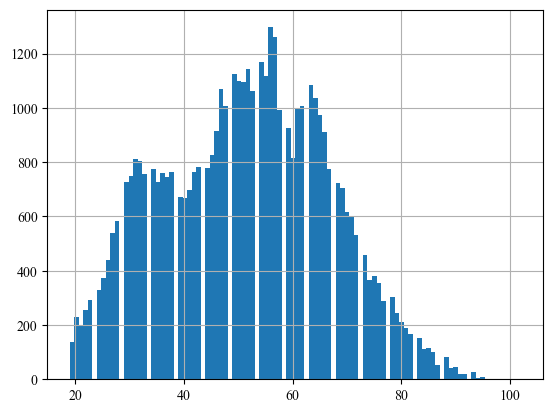

In [17]:
ALL_data['年龄'].hist(bins=100)

<AxesSubplot:>

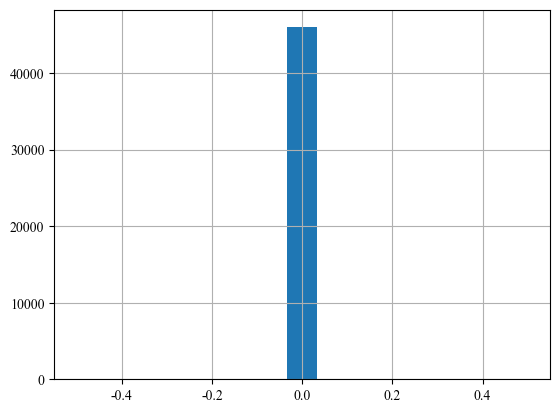

In [18]:
ALL_data['Q'].hist(bins=15)

<AxesSubplot:>

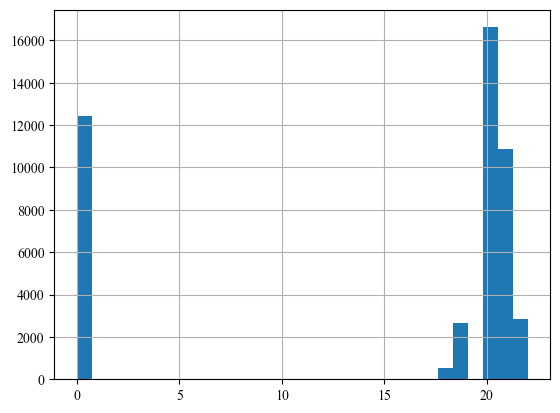

In [19]:
ALL_data['year'].hist(bins=30)

In [20]:
def is_not_digit(n):
    return not n.isdigit()
mask = ALL_data['住院号'].map(is_not_digit)
filtered_data = ALL_data[mask]

In [21]:
filtered_data['住院号']

5869     R18730923
7124     R18822211
7125     R18822211
7126     R18822211
8120     R18794841
           ...    
52028    R18642436
52043    R18642436
52044    R18642436
66639    R18515467
68678    R18518288
Name: 住院号, Length: 128, dtype: object